In [9]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 16.5 MB/s eta 0:00:00


In [20]:
from music21 import converter, instrument, note, chord, stream
import numpy
from matplotlib import pyplot as plt
import keras
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from keras import Sequential, Model, regularizers
from keras.layers import LSTM, Dropout, Dense, Activation, Input, concatenate
import pandas as pd
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Attention, Bidirectional
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Embedding
import tensorflow as tf
from tqdm import tqdm
import numpy as np
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as smape_loss
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
!unzip dataset.zip

unzip:  cannot find or open dataset.zip, dataset.zip.zip or dataset.zip.ZIP.


In [11]:
def get_notes(midi):
  notes = []

  notes_from_midi = midi.flatten().notesAndRests
  notes_sorted = sorted(notes_from_midi, key=lambda note: note.offset)

  prev_start = notes_sorted[0].offset

  for element in notes_sorted:
    if isinstance(element , note.Note):
      notes.append((float(element.offset), float(element.volume.velocity),float(element.seconds), str(element.pitch), float(element.offset-prev_start)))
    elif isinstance(element, chord.Chord):
      #notes.append((float(element.offset), float(element.volume.velocity), float(element.seconds), '+'.join(str(n) for n in element.normalOrder)))
      for noteChord in element.pitches:
        notes.append((float(element.offset),float(element.volume.velocity), float(element.seconds), str(noteChord), float(element.offset-prev_start)))

    elif isinstance(element, note.Rest):
        # Bizarre car main gauche et droite flatten (réunie)
        # Voir autre implémentation
        pass
        #notes.append((float(element.offset), 0,float(element.seconds), "REST", float(element.offset-prev_start)))

    prev_start = element.offset
  return notes



In [ ]:
input_note, output_note = [], []
input_offset, output_offset = [], []
input_volume, output_volume = [], []
input_duration, output_duration = [], []

note_all_songs = []
for folder in tqdm(os.walk("dataset")):
    if len(folder) != 3:
      continue
    else:
      for file in folder[2]:
        file_path = str(folder[0])+"/"+file

        # convertit la piste midi
        midi = converter.parse(file_path)

        # récupère les notes, volume, dureées...
        notes = get_notes(midi)

        # ajoute à une liste globale
        note_all_songs.append(notes)

In [13]:
# fais un dataframe à partir de toutes les notes (sans distinctions)
df = pd.DataFrame([], columns=['debut_note','volume','durée(s)', 'pitch/chord', 'offset'])
df = df.reset_index(drop=True)
for elem in note_all_songs:
    df2 = pd.DataFrame(elem, columns=['debut_note','volume','durée(s)', 'pitch/chord', 'offset'])
    df2 = df2.reset_index(drop=True)
    df =pd.concat([df,df2])
    df = df.reset_index(drop=True)

In [14]:
def check_pitch(x):
  if ('+' in x) or x.isdigit():
        notes_in_chord = x.split('+')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord =chord.Chord(notes).pitches[0].midi
        return new_chord
    # pattern is a note
  elif 'REST' in x:
    return 0
  else:
        new_note = note.Note(x).pitch.midi
        return new_note

In [15]:
df

,debut_note,volume,durée(s),pitch/chord,offset
0,0.0,50.0,0.749298,B-4,0.00
1,0.0,40.0,0.749298,B-3,0.00
2,2.0,45.0,0.413365,F4,2.00
3,2.0,36.0,0.413365,F3,0.00
4,3.0,50.0,0.742345,D4,1.00
...,...,...,...,...,...
17769,581.0,76.0,0.129825,E5,0.75
17770,581.0,59.0,0.129825,C4,0.00
17771,582.0,85.0,0.519301,C5,0.75
17772,582.0,51.0,0.519301,C3,0.00


In [16]:
def prepare_sequence(data, sequence_length, network_input, network_output):
  # create input sequences and the corresponding outputs
  for i in range(0, len(data) - sequence_length, 1):
      sequence_in = data[i:i + sequence_length]
      sequence_out = data[i + sequence_length]
      network_input.append(sequence_in)
      network_output.append(sequence_out)
  return (network_input, network_output)

def reshape_array_input(array_tensor, sequence_length):
  n_patterns = len(array_tensor)
  array_reshaped = numpy.reshape(array_tensor, (n_patterns, sequence_length, -1))
  return array_reshaped

def reshape_array_output(array_tensor, sequence_length):
  n_patterns = len(array_tensor)
  array_reshaped = numpy.reshape(array_tensor, (len(array_tensor), -1))
  return array_reshaped


In [17]:
def plot_ys(*series, labels=None):
  nb_series=len(series)
  colors = ['blue', 'red', 'green']
  fig = []
  data = None
  for i in range(nb_series):
    fig.append(px.line(series[i]))
    if labels is not None:
      fig[i].update_traces(name= labels[i])
    fig[i].update_traces(line_color=colors[i])
    if data==None:
      data = fig[i].data
    else:
      data = data + fig[i].data
  figFinal = go.Figure(data = data)
  figFinal.show()

In [25]:
df_music = pd.DataFrame(note_all_songs[0], columns=['debut_note','volume','durée(s)', 'pitch/chord', 'step'])
df_music['MIDI Pitch'] = df_music["pitch/chord"].apply(check_pitch)

note_standardized = StandardScaler().fit(df_music[['MIDI Pitch']])
df_music['note_std'] = note_standardized.transform(df_music[['MIDI Pitch']])

In [19]:
px.line(df_music['MIDI Pitch'])

In [26]:
px.line(df_music['note_std'])

## Décomposition STL

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
result = STL(df_music['note_std'], period = 6).fit()

In [35]:
px.line(result.observed)

In [36]:
px.line(result.trend)

In [37]:
px.line(result.seasonal)

In [41]:
y = df_music['note_std']
y_train, y_test = temporal_train_test_split(y, test_size=25)

In [42]:
y_test

4125   -1.451511
4126   -1.048260
4127    0.665559
4128    0.766372
4129    0.463934
4130    0.262308
4131   -2.157202
4132   -1.753950
4133   -1.451511
4134   -0.947447
4135   -0.241757
4136   -0.040131
4137   -0.241757
4138   -0.443382
4139   -2.258014
4140   -2.661266
4141   -0.544195
4142   -0.443382
4143   -0.745821
4144   -0.947447
4145   -2.157202
4146    0.665559
4147    0.967998
4148    1.472063
4149   -3.366956
Name: note_std, dtype: float64

In [43]:
plot_ys(y_train, y_test, labels=["y_train", "y_test"])


In [44]:
fh = np.arange(1,len(y_test)+1)
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25])

## Mise en place des méthode statistiques

### Approches naïves

In [45]:
y_train = y_train[-200:]

In [49]:
# using sktime

from sktime.forecasting.naive import NaiveForecaster
forecaster = NaiveForecaster(strategy="last", sp=9)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_pred, y_test)

2.3781263676279574

In [50]:
from sktime.forecasting.compose import make_reduction


## KNeighbors

In [70]:
#from sktime.forecasting.compose import ReducedForecaster as ReducedRegressionForecaster
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor


regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(estimator=regressor,
                                         window_length=2, strategy="direct")
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

1.5010339975268354

### Fine tuning

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)

In [ ]:
regressor = KNeighborsRegressor()
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
param_grid = {"window_length": [7, 12, 15]}

# We fit the forecaster on an initial window which is 80% of the historical data
# then use temporal sliding window cross-validation to find the optimal hyper=parameters
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=param_grid
)

In [ ]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

In [ ]:
gscv.best_params_
gscv.best_forecaster_

## RandomForest

In [80]:
from sklearn.ensemble import RandomForestRegressor


regressor = RandomForestRegressor(n_estimators=500, max_depth=5)
forecaster = make_reduction(estimator=regressor, window_length=15,
                                         strategy="recursive")
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

0.9974818723113992

### Fine tuning

In [96]:
from sklearn.model_selection import GridSearchCV
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import SlidingWindowSplitter, ForecastingGridSearchCV

# paramètre 'n_estimator' de scikit-learn
regressor_param_grid = {"n_estimators": [100, 200]}#, 200, 300]}
forecaster_param_grid = {"window_length": [5,  10]}#,15,25]}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(RandomForestRegressor(), param_grid=regressor_param_grid)
forecaster = make_reduction(
    regressor, scitype="tabular-regressor", strategy="recursive"
)
# We fit the forecaster on an initial window which is 80% of the historical data
# then use temporal sliding window cross-validation to find the optimal hyper=parameters
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=forecaster_param_grid
)

In [98]:
cv

SlidingWindowSplitter(initial_window=160, window_length=20)

In [97]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
print(smape_loss(y_test, y_pred))

KeyboardInterrupt: ignored

In [ ]:
print(gscv.best_params_)
print(gscv.best_forecaster_.estimator.estimator.get_params())

## Exponential Smoothing

#### Sktime

In [83]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
forecaster = ExponentialSmoothing(trend="add", seasonal="additive",
                                  sp=7)
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

1.4907733608700275

#### Statsmodels

In [87]:
import statsmodels as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

fit1 = ExponentialSmoothing(y_train, seasonal_periods=7,
                            trend='add', seasonal='add', use_boxcox=False,
                            initialization_method="estimated").fit()


In [88]:
y_pred = fit1.forecast(25)

In [89]:
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

1.4907733608700275

#### ETSModel

In [90]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [91]:
model = ETSModel(y_train.astype('float64'), error="add", trend="add", seasonal="add",
                damped_trend=True, seasonal_periods=7)
fit = model.fit()

In [92]:
y_pred = fit.forecast(25)

In [93]:
simulated = fit.simulate(anchor="end", nsimulations=36, repetitions=100)

In [94]:
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
print(smape_loss(y_test, y_pred))

1.491416995599325


In [95]:
px.line(simulated)

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



## ARIMA

In [ ]:
data = df_music['MIDI Pitch']

<Axes: >

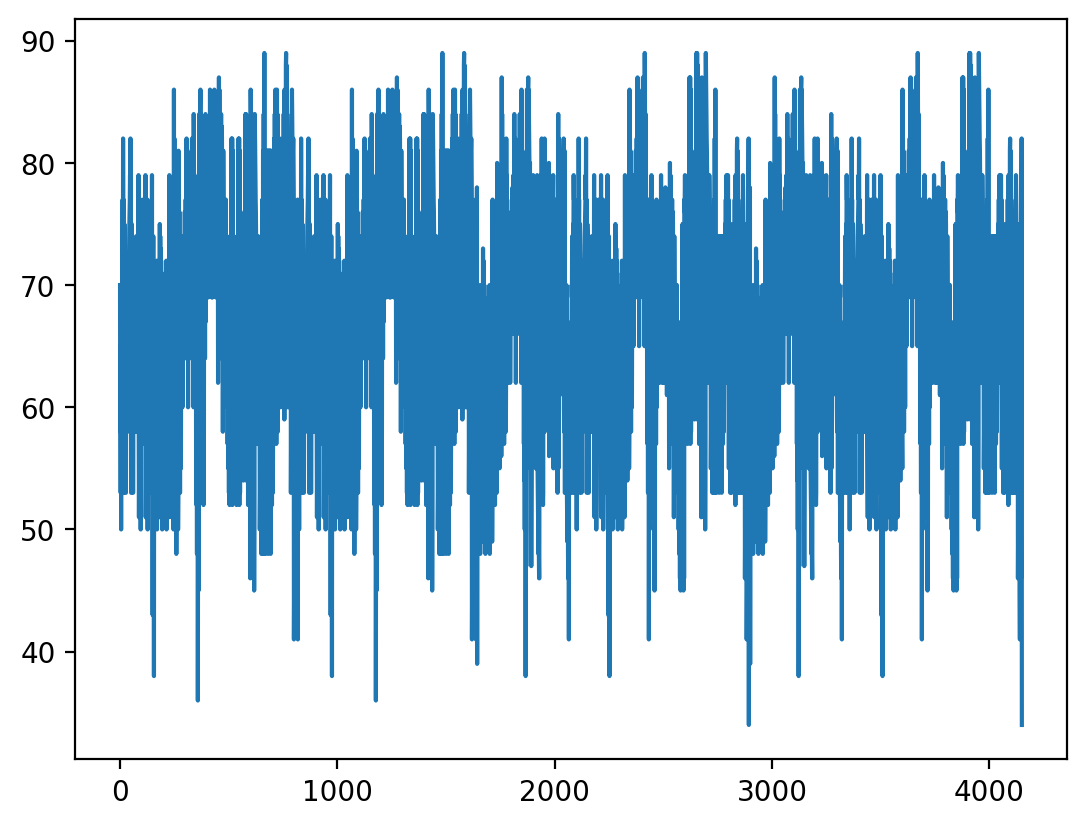

In [ ]:
data.plot()

<Axes: >

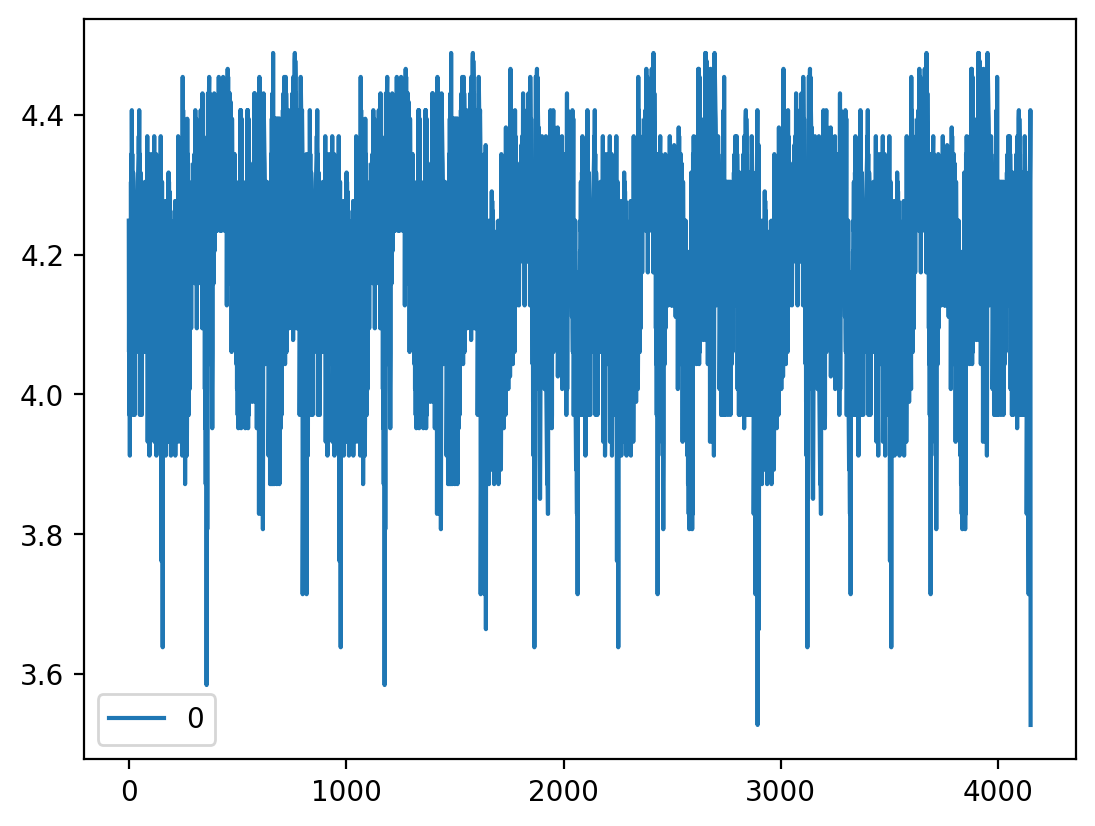

In [ ]:
from scipy.stats import boxcox
a = boxcox(data, 0)
a = pd.Series(a)
pd.DataFrame(a).plot()

In [ ]:
from statsmodels.tsa.seasonal import STL, seasonal_decompose
out = seasonal_decompose(a, period=6)

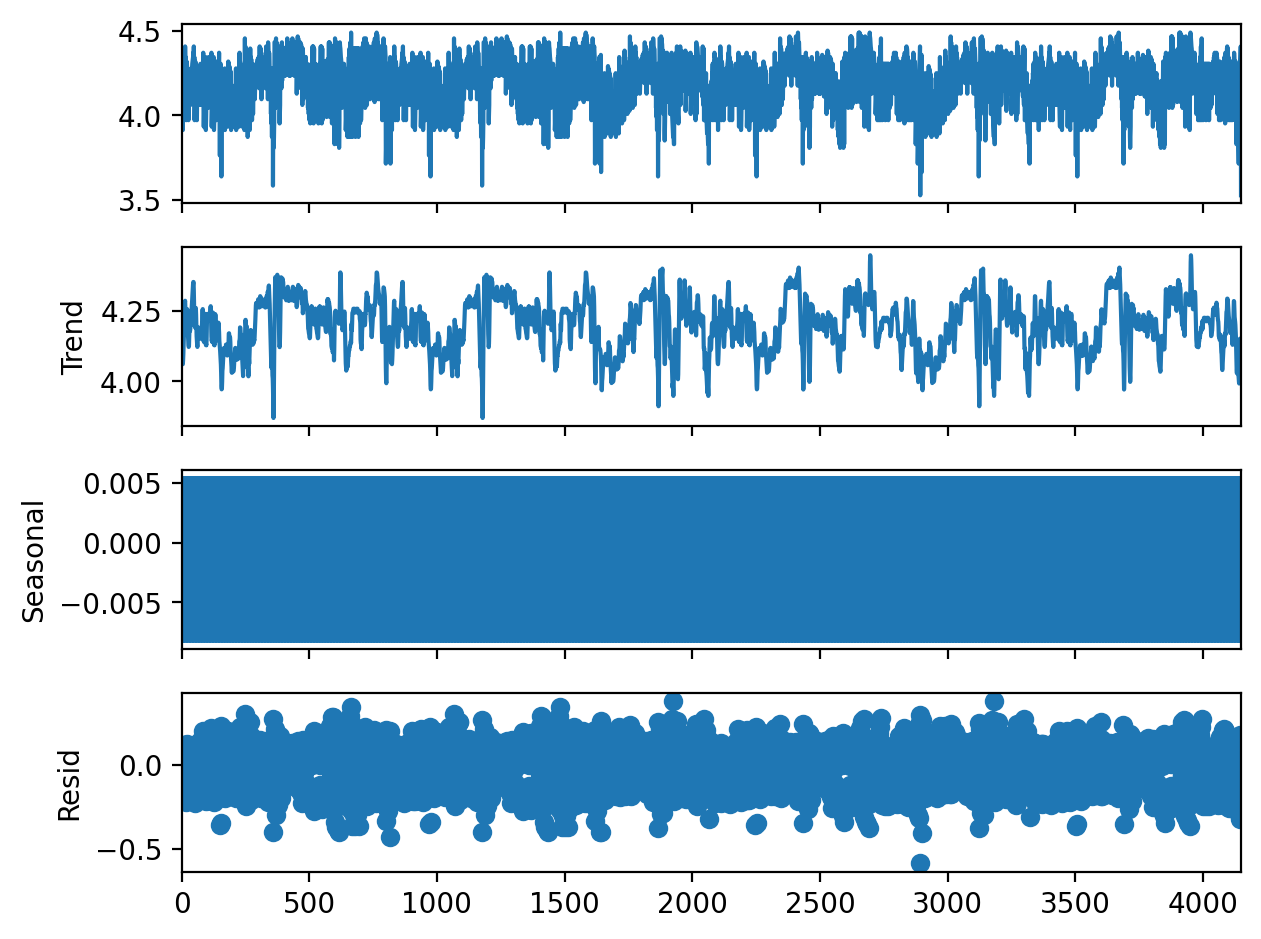

In [ ]:
out.plot();

<Axes: >

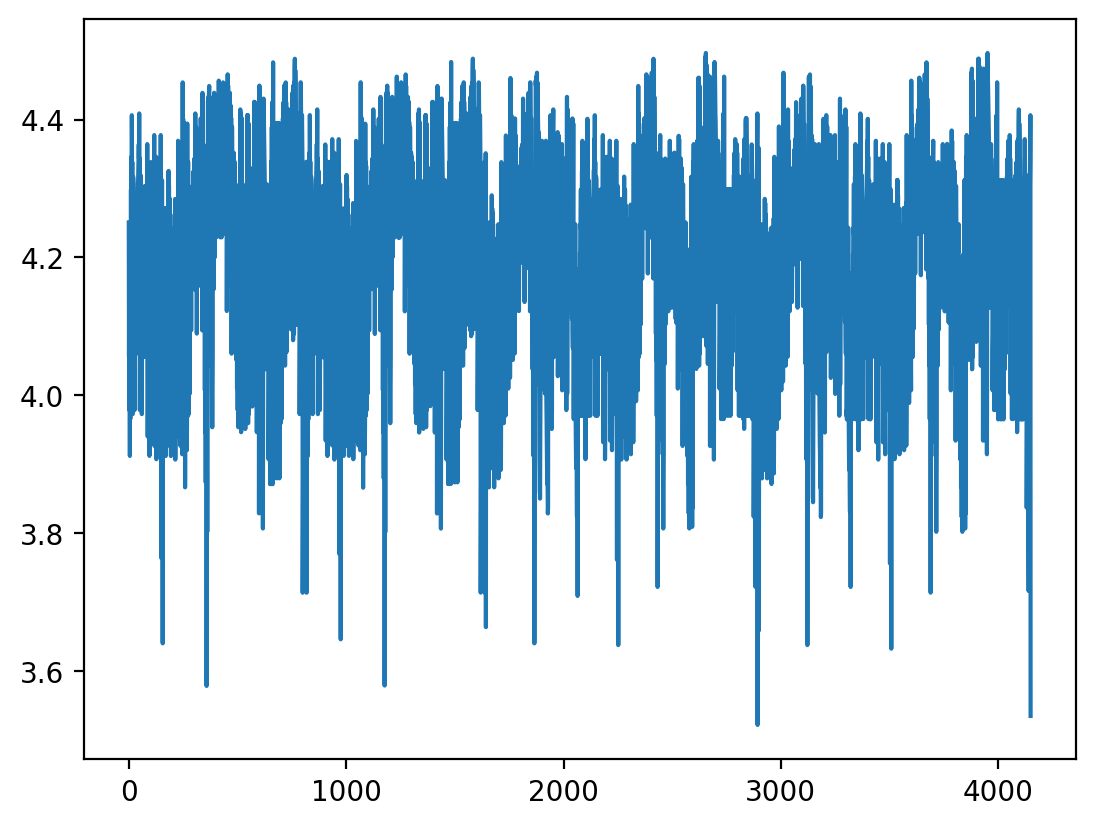

In [ ]:
x =  out.observed - out.seasonal
x.plot()

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
adf, pa, *_  = adfuller(x.dropna())
print("p-value adf : ", pa)

p-value adf :  3.417353881856362e-09


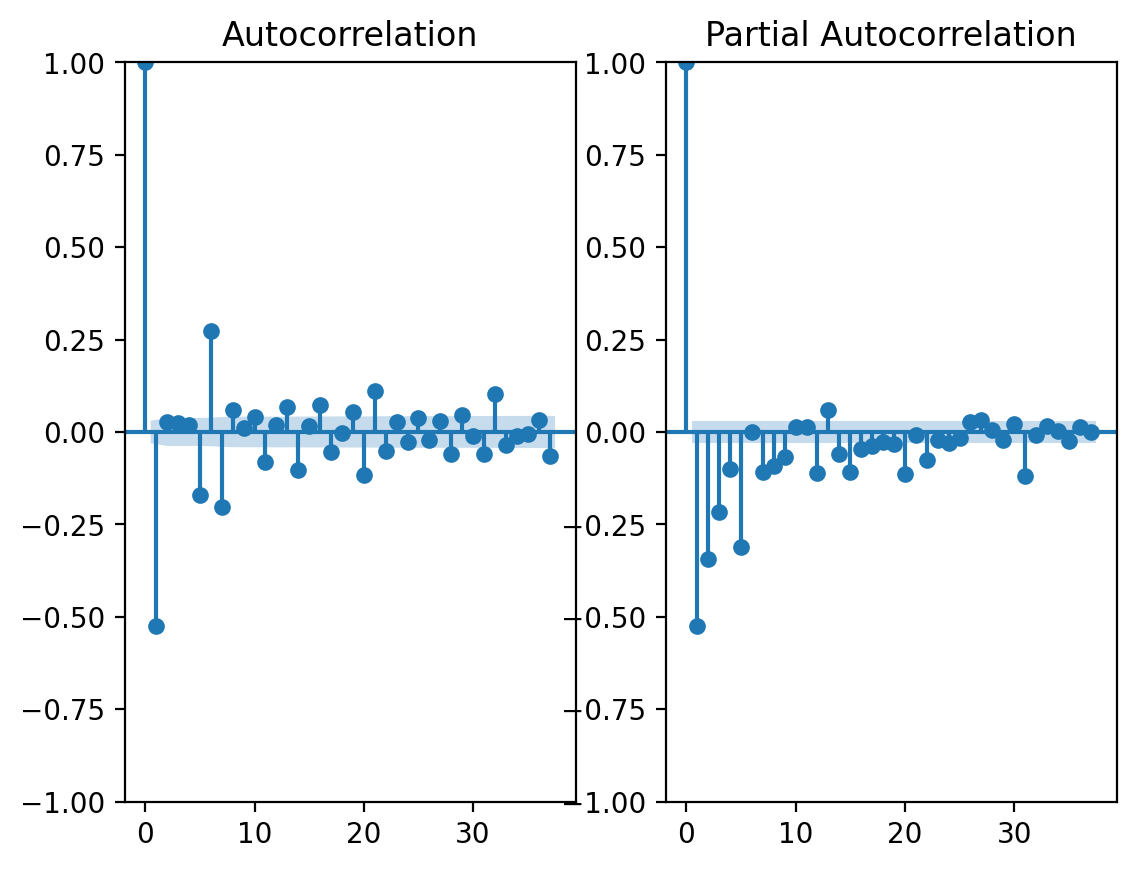

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df = data.diff()
fig, ax = plt.subplots(1,2)
plot_acf(df.dropna(), ax=ax[0])
plot_pacf(df.dropna(), ax=ax[1]);

ARIMA(5,1,0)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
mod = ARIMA(data, order=(5,1,0))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             MIDI Pitch   No. Observations:                 4150
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -15036.480
Date:                Fri, 03 Nov 2023   AIC                          30084.960
Time:                        10:06:17   BIC                          30122.944
Sample:                             0   HQIC                         30098.399
                               - 4150                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8408      0.013    -66.057      0.000      -0.866      -0.816
ar.L2         -0.6487      0.015    -42.688      0.000      -0.678      -0.619
ar.L3         -0.4750      0.017    -28.141      0.000      -0.508      -0.442
ar.L4         -0.3573      0.016    -22.398      0.000      -0.389      -0.326
ar.L5         -0.3151      0.013    -23.910      0.000      -0.341      -0.289
sigma2        82.3013      1.686     48.807      0.000      78.996      85.606
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                26.40
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.09
Prob(H) (two-sided):                  0.62   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

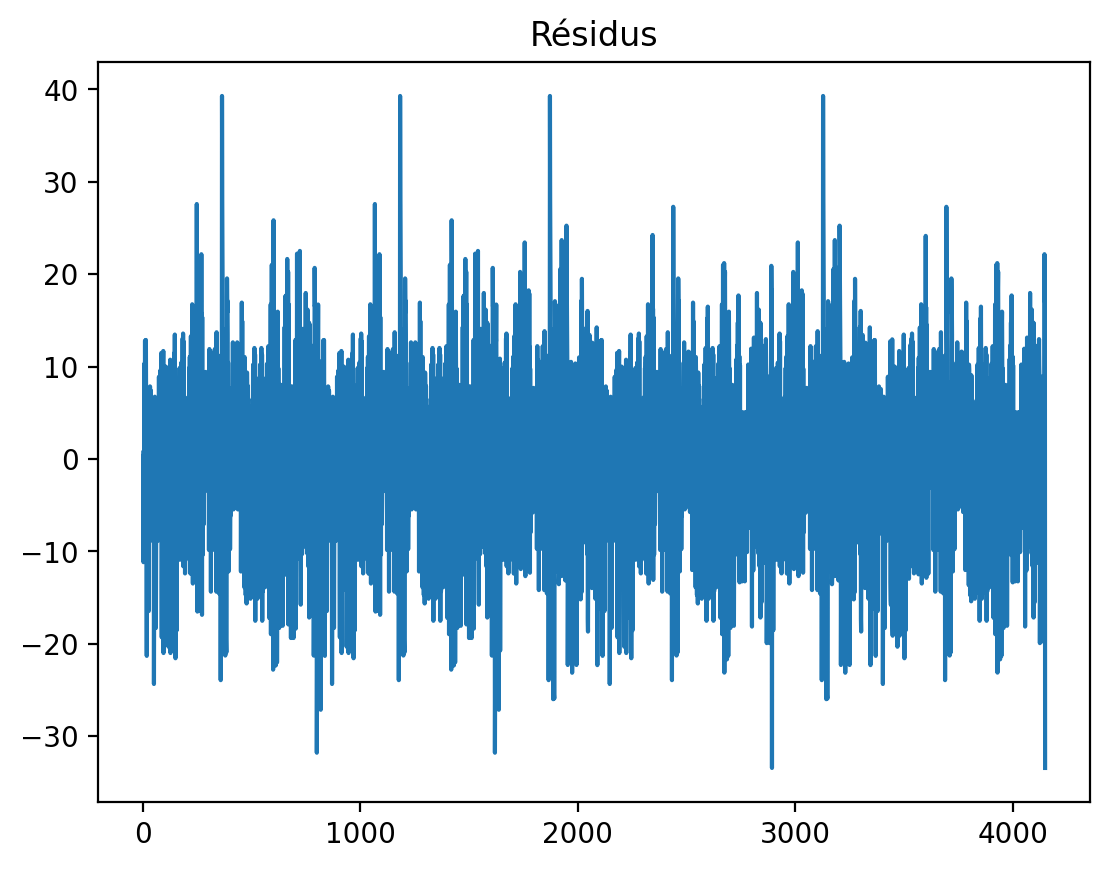

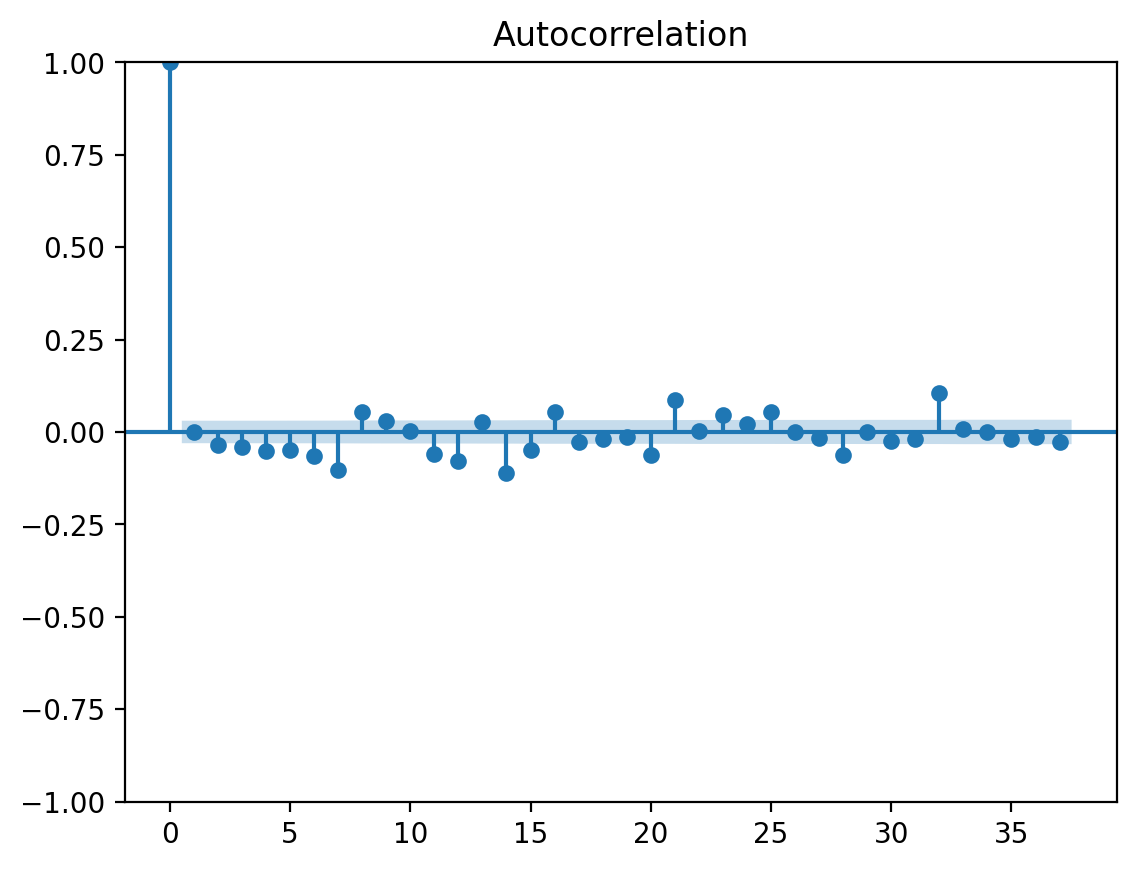

In [ ]:
residus = res.resid[2:]
residus.plot(title="Résidus")
plot_acf(residus);

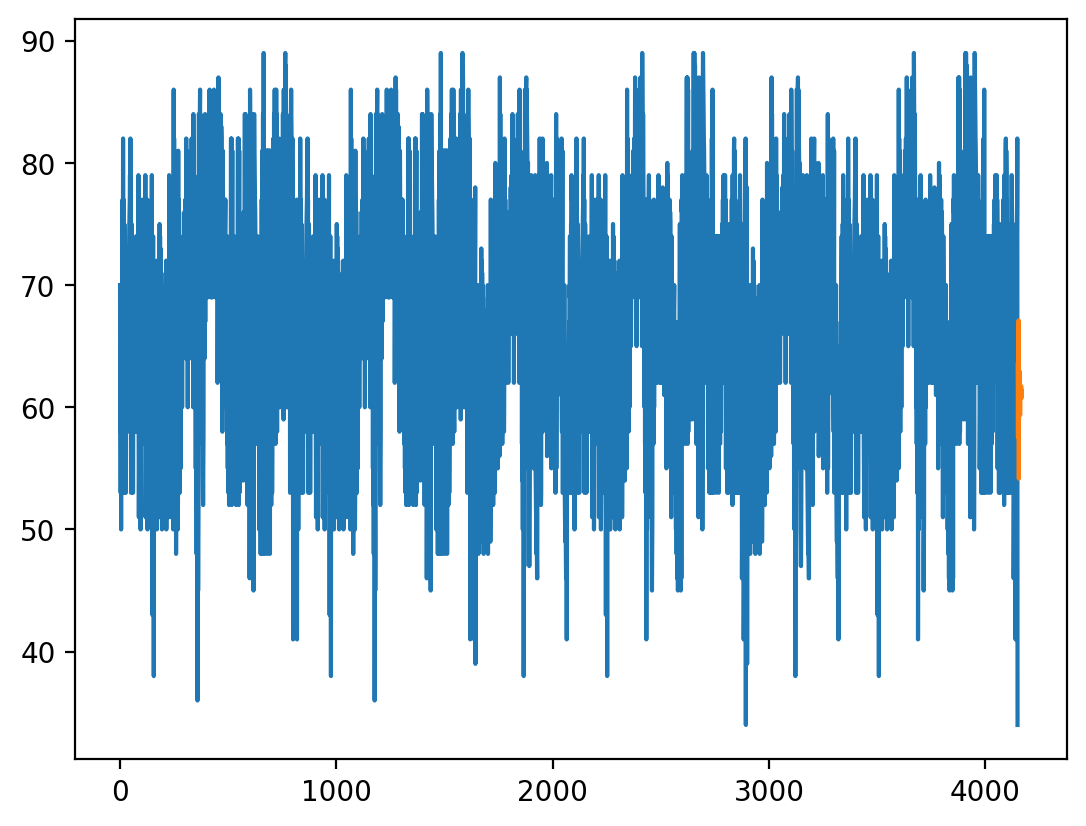

In [ ]:
plt.plot(data)
plt.plot(res.forecast(20))

### SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import  SARIMAX

train = data[:-20]
test = data[-20:]

mod = SARIMAX(train, order=(5,1,0), simple_differencing=False,
              enforce_stationarity=False) #seasonal_order=(3,1,0,12)

res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             MIDI Pitch   No. Observations:                 4130
Model:               SARIMAX(5, 1, 0)   Log Likelihood              -14932.543
Date:                Fri, 03 Nov 2023   AIC                          29877.085
Time:                        10:06:58   BIC                          29915.033
Sample:                             0   HQIC                         29890.516
                               - 4130                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8425      0.013    -66.081      0.000      -0.867      -0.818
ar.L2         -0.6493      0.015    -42.441      0.000      -0.679      -0.619
ar.L3         -0.4712      0.017    -27.676      0.000      -0.505      -0.438
ar.L4         -0.3537      0.016    -22.209      0.000      -0.385      -0.323
ar.L5         -0.3131      0.013    -23.794      0.000      -0.339      -0.287
sigma2        81.7691      1.684     48.556      0.000      78.468      85.070
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                24.11
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                            -0.08
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pred = res.get_forecast(20)


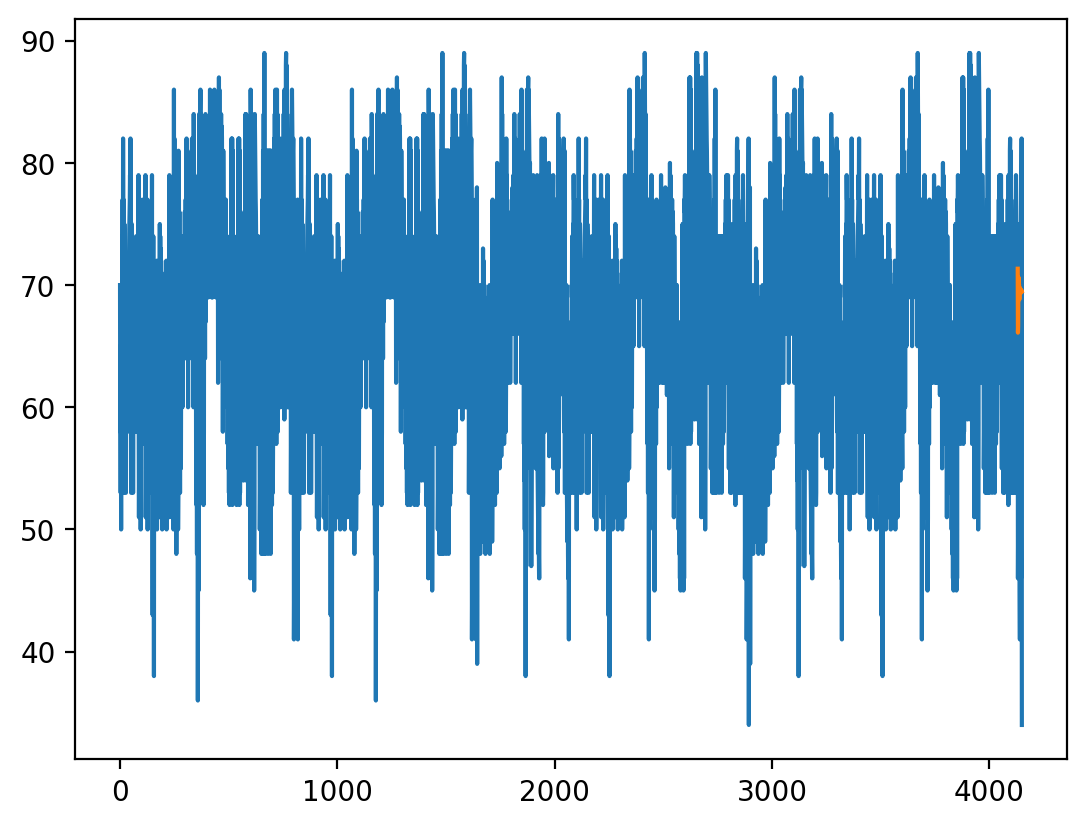

In [ ]:
plt.plot(data)
plt.plot(res.forecast(20))

### ARMAX

In [ ]:
data_full = df_music[['MIDI Pitch', 'volume']]
data_full

,MIDI Pitch,volume
0,70,50.0
1,58,40.0
2,65,45.0
3,53,36.0
4,62,50.0
...,...,...
4145,46,59.0
4146,74,65.0
4147,77,65.0
4148,82,65.0


In [ ]:
import statsmodels.api as sm


In [ ]:
endog = data_full['MIDI Pitch']
exog = sm.add_constant(data_full['volume'])

In [ ]:
mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(5,1,0))
res = mod.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:             MIDI Pitch   No. Observations:                 4150
Model:               SARIMAX(5, 1, 0)   Log Likelihood              -13943.297
Date:                Fri, 03 Nov 2023   AIC                          27902.594
Time:                        10:12:29   BIC                          27953.239
Sample:                             0   HQIC                         27920.513
                               - 4150                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.879e-08   3.84e-10   -127.010      0.000   -4.95e-08    -4.8e-08
volume         0.6377      0.010     62.718      0.000       0.618       0.658
ar.L1         -0.7583      0.011    -69.635      0.0

In [ ]:
np.sum(np.abs(res.resid.values)**2)

203021.49524461993

In [ ]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog,  order=(1,0,1))
res = mod.fit(disp=False)
print(res.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:             MIDI Pitch   No. Observations:                 4150
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -15077.951
Date:                Fri, 03 Nov 2023   AIC                          30161.901
Time:                        10:12:53   BIC                          30180.894
Sample:                             0   HQIC                         30168.621
                               - 4150                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   4170.540      0.000       0.999       1.000
ma.L1         -0.8839      0.006   -137.184      0.000      -0.897      -0.871
sigma2        83.7050      1.903     43.990      0.0

In [ ]:
np.sum(np.abs(res.resid.values)**2)

352277.5470733637

<Axes: xlabel='MIDI Pitch', ylabel='volume'>

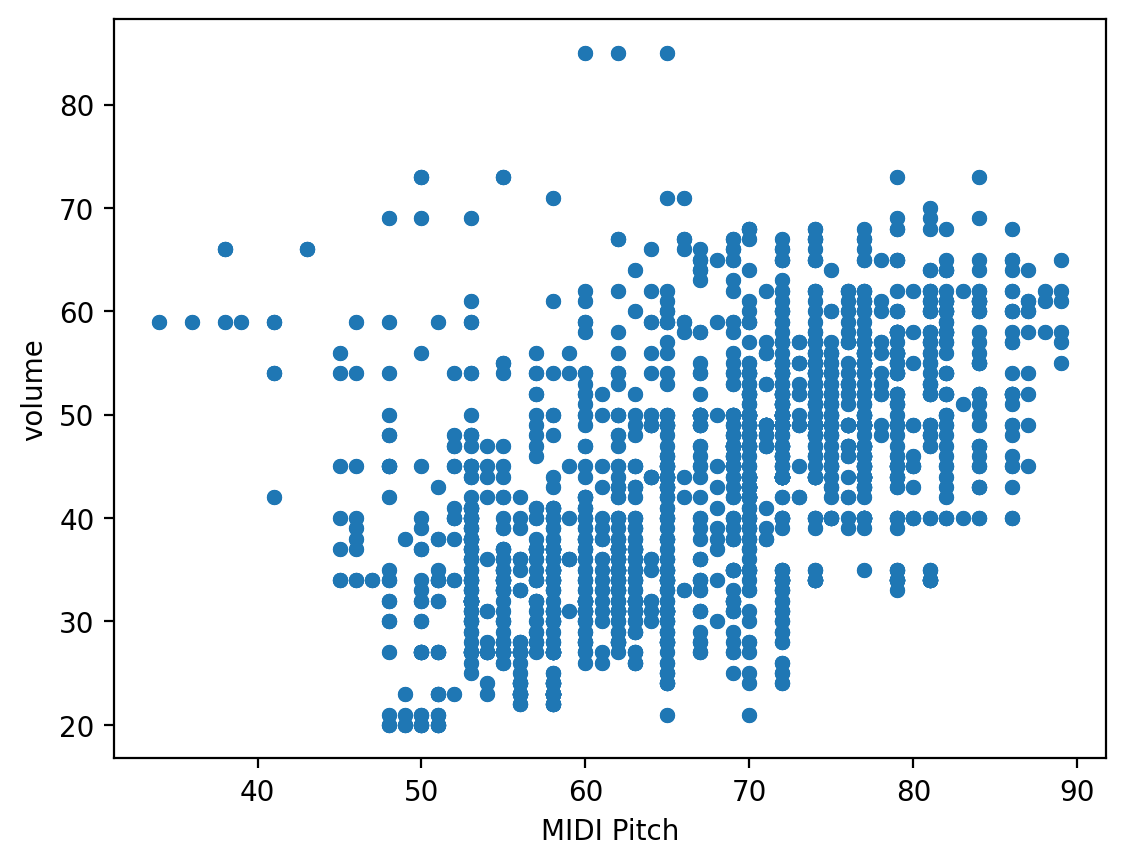

In [ ]:
data_full.plot(kind='scatter', x='MIDI Pitch', y='volume')

<Axes: >

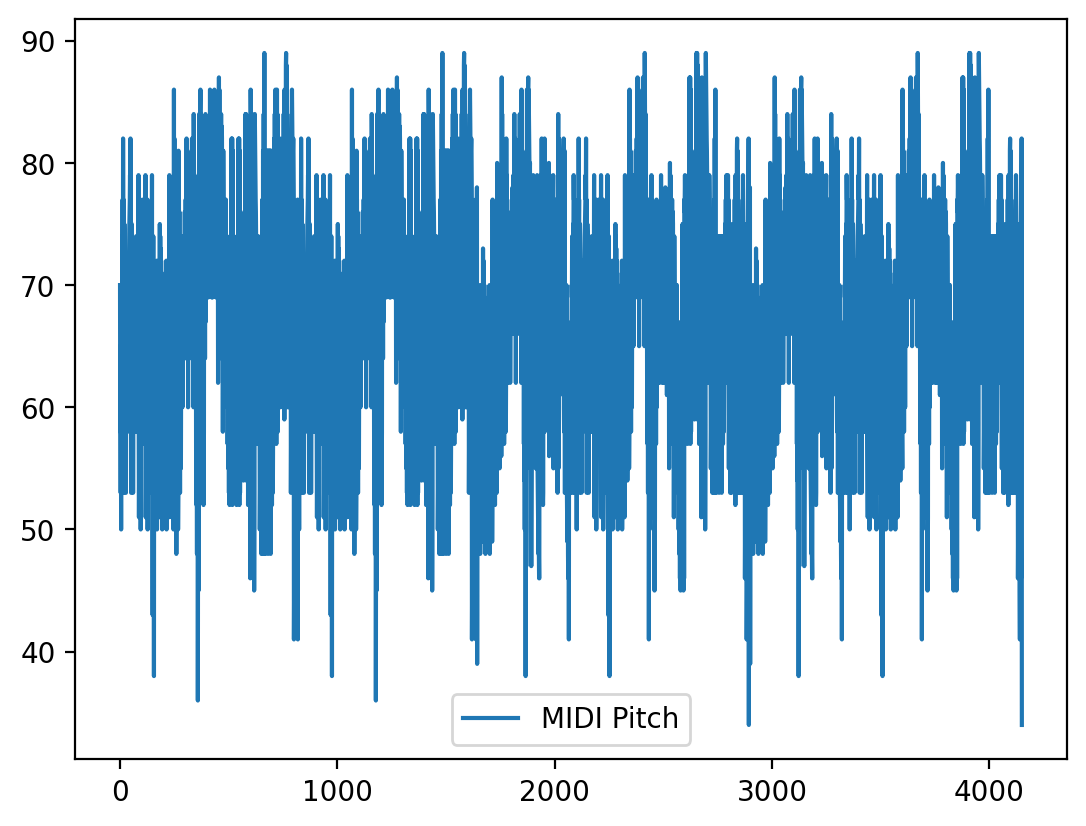

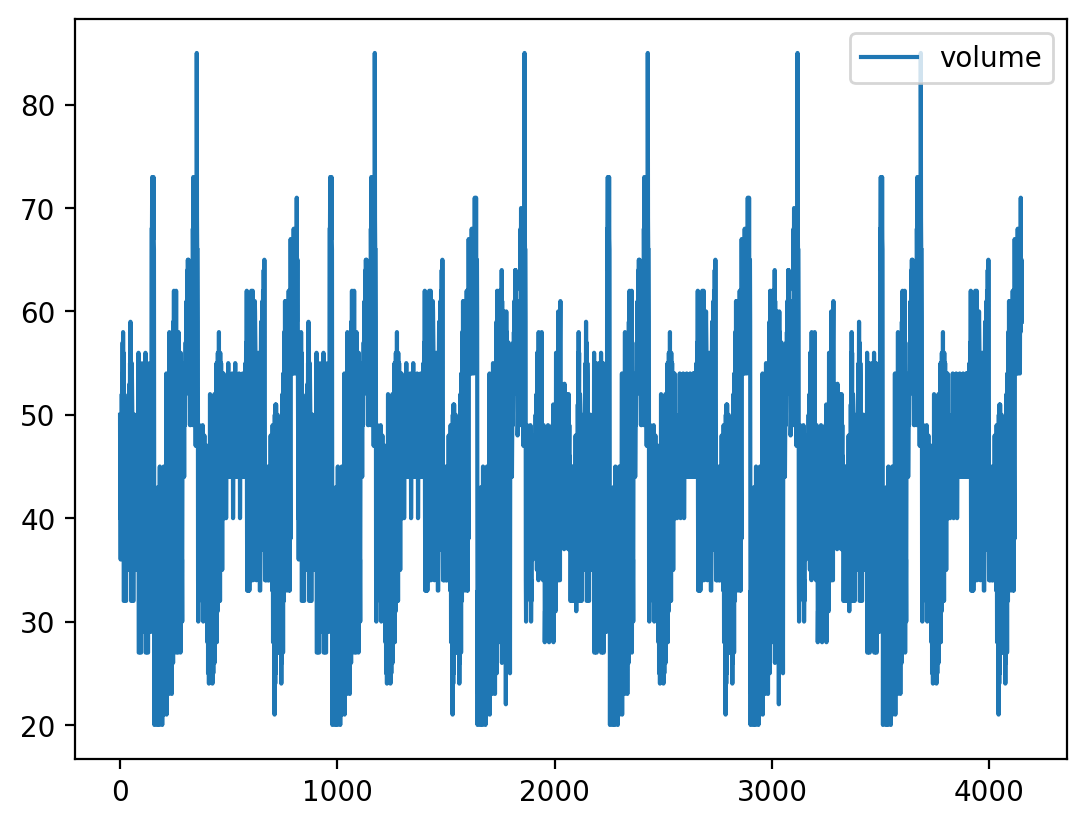

In [ ]:
data_full.plot(kind='line', y='MIDI Pitch')
data_full.plot(kind='line', y='volume')

### Auto ARIMA

In [ ]:
data_auto_arima = df_music[['MIDI Pitch']]
data_auto_arima

,MIDI Pitch
0,70
1,58
2,65
3,53
4,62
...,...
4145,46
4146,74
4147,77
4148,82


In [ ]:
!pip install pmdarima


In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
stepwise_model = auto_arima(data_auto_arima, start_p=0, start_q=0,
                           max_p=1, max_q=1, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=9.50 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=35318.482, Time=0.34 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=32845.682, Time=3.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=16.16 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=33965.558, Time=0.28 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=32364.223, Time=5.36 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=33.07 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=13.37 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=33680.158, Time=5.66 sec


In [ ]:
stepwise_model.aic()

NameError: ignored

In [ ]:
stepwise_model.seasonal_order

In [ ]:
train = data_auto_arima[:-20]
test = data_auto_arima[-20:]

In [ ]:
stepwise_model.fit(train)

In [ ]:
future_forecast, ci = stepwise_model.predict(n_periods=20, return_conf_int=True,alpha=0.05)

In [ ]:
stepwise_model.plot_diagnostics();

In [ ]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])

In [ ]:
future_forecast_ci = pd.DataFrame(ci, index=test.index, columns = ['lwb', 'ub'])

In [ ]:
pd.concat([test,future_forecast, future_forecast_ci],axis=1).plot()

In [ ]:
future_forecast2 = future_forecast

In [ ]:
out = pd.concat([data,future_forecast2,future_forecast_ci],axis=1).plot(
    #colormap=('blue', 'green', 'gray', 'gray'),
    legend = "bottom_right",)